In [1]:
from datetime import datetime
from uuid import uuid4
from dataclasses import dataclass

from ipynb.fs.full.quantumsystem import QuantumSystem, qs, System, IntegerSystem, FloatSystem, MetaSystem, HyperSystem

In [2]:
class GameEventObject(System):
    """ Connects a game object to the gamestate """

class RoundCount(IntegerSystem):
    """ Records the number of rounds since the game began """

class GameEventTime(System):
    """ Which Team Is Active"""

class GameEventType(System):
    """ Which Team Is Active"""
    
class GameEventFaction(System):
    """ Which Team Is Active"""
    
class GameEventValue(System):
    """ Which Team Is Active"""
    
class GameEventTarget(FloatSystem):
    """ Which Team Is Active"""
    
class GameEventResult(System):
    """ Which Team Is Active"""


@GameEventResult.sd
@GameEventTarget.sd
@GameEventValue.sd
@GameEventObject.sd
@GameEventFaction.sd
@GameEventType.sd
@RoundCount.sd
class GameEvent(HyperSystem):
    @classmethod
    def declare_event(cls, **kwargs):
        return GameEvents.declare_event(**kwargs)

    @classmethod
    @GameEventResult.decorator("gameEvent")
    def set_result(cls, gameEvent, newResult, gameeventresult):
        GameEventResult.set_relationship(gameEvent, newResult)
        
    def resolve(self, result):
        GameEvents.resolve_event(self.entity, result)


@dataclass
class GameEvents(GameEvent, MetaSystem):
    """ Game Event Records """
    entity: str = "DeclaredEvents"

    @classmethod
    def generate_meta_anchor(cls, anchor):
        return f"{cls.__name__}--{uuid4()}--{datetime.utcnow().isoformat().replace(':', '_')}"

    @classmethod
    def get_events(cls, terminant="DeclaredEvents"):
        return [GameEvent(r[0]) for r in qs.get(edge_name=cls, terminant=terminant)]

    @classmethod
    def get_declared_events(cls):
        return cls.get_events("DeclaredEvents")

    @classmethod
    def get_declared_no_action_events(cls):
        de = cls.get_declared_events()
        return [e for e in de if e.GameEventType.terminant == "NoAction"]

    @classmethod
    def get_resolved_events(cls):
        return cls.get_events("ResolvedEvents")

    @classmethod
    def move_event(cls, gameEvent, oldAnchor, newAnchor):
        qs.drop(gameEvent, cls.__name__, oldAnchor)
        qs.put(gameEvent, cls.__name__, newAnchor)

    @classmethod
    def get_existing_declarations(cls, gameEventObject):
        declared_events = cls.get_declared_events()
        return [event for event in declared_events if event.GameEventObject.terminant == gameEventObject]

    @classmethod
    def drop_existing_declarations(cls, gameEventObject):
        currentDeclarations = cls.get_existing_declarations(gameEventObject)
        for currentEvent in currentDeclarations:
            currentEvent.drop()
            QuantumSystem.drop(entity=currentEvent.entity, edge_name=cls.__name__, terminant="DeclaredEvents")

    @classmethod
    def declare_event(cls, **kwargs):
        cls.drop_existing_declarations(kwargs['GameEventObject'])
        newEvent = cls(entity="DeclaredEvents", **kwargs)
        return newEvent

    @classmethod
    def resolve_event(cls, gameEvent, result):
        GameEvent.set_result(gameEvent=gameEvent, newResult=result)
        cls.move_event(gameEvent=gameEvent, oldAnchor="DeclaredEvents", newAnchor="ResolvedEvents")
    
    def __post_init__(self):
        self.meta_anchor = self.entity
        self.entity = self.generate_meta_anchor(self.entity)
        QuantumSystem.add_entity(self.entity, **{type(self).__name__: self.meta_anchor})
        self.update_system_attributes()

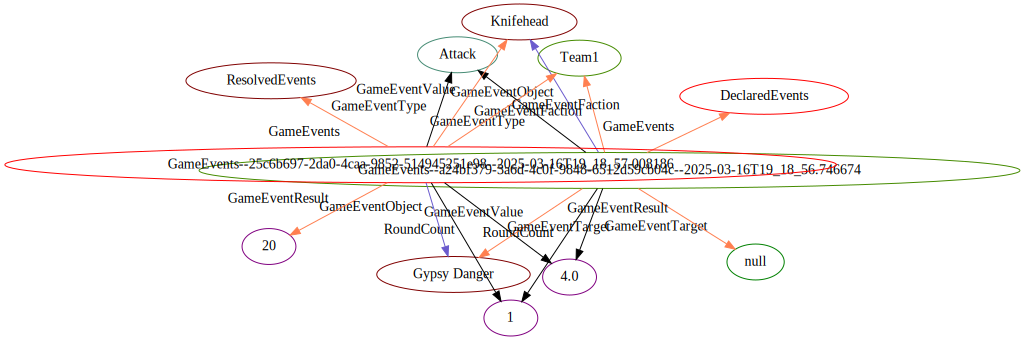

In [3]:
if __name__ == "__main__":
    from IPython.display import display

    qs.reset()
    t1 = GameEvent.declare_event(**{
        "RoundCount": "1",
        "GameEventType": "Attack",
        "GameEventFaction": "Team1",
        "GameEventObject": "Knifehead",
        "GameEventValue": "Oil Tanker",
        "GameEventTarget": "4",
        "GameEventResult": "null"})
    t0 = GameEvent.declare_event(**{
        "RoundCount": "1",
        "GameEventType": "Attack",
        "GameEventFaction": "Team1",
        "GameEventObject": "Knifehead",
        "GameEventValue": "Gypsy Danger",
        "GameEventTarget": "4",
        "GameEventResult": "null"})
    assert len(GameEvents.get_declared_events()) == 1
    event = GameEvent.declare_event(**{
        "RoundCount": "1",
        "GameEventType": "Attack",
        "GameEventFaction": "Team1",
        "GameEventObject": "Gypsy Danger",
        "GameEventValue": "Knifehead",
        "GameEventTarget": "4",
        "GameEventResult": "null"})
    assert len(GameEvents.get_declared_events()) == 2
    event.resolve("20")
    assert len(GameEvents.get_events("DeclaredEvents")) == 1
    assert len(GameEvents.get_resolved_events()) == 1
    assert event.entity in [ge.entity for ge in GameEvents.get_resolved_events()]
    display(qs.render())